In [47]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from PIL import Image
from astropy import units as u
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [48]:
NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0    

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [49]:
dir_cadences="D:\Projet de recherche\Stage/cadences"
all_my_cadence_files=["cadence_lmc_baseline2018a_extr_v1.csv",
                      "cadence_lmc_baseline_2snaps_v1_extr_v1.csv",
                      "cadence_lmc_baseline_v1_extr_v1.csv",
                      "cadence_lmc_rolling_nm_scale1_extr_v1.csv",
                      "cadence_lmc_rolling_scale0_extr_v1.csv"
                     ]
all_names = ["2018a", "2snaps", "v1", "rolling_scale1", "rolling_scale0"]

In [50]:
sel_cadence_idx = 0

In [51]:
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,10033,13,59865.307442,22.042763,y,1.326809,17.868655,0.734701,138,72.000005,-70.933132
1,10158,13,59865.364815,21.847938,y,1.362533,17.829956,0.859026,122,88.568878,-72.896915
2,10160,13,59865.365718,21.894638,y,1.315613,17.861954,0.841153,150,81.777206,-70.757749
3,10161,13,59865.366169,21.944466,y,1.267955,17.897698,0.822736,190,84.972540,-68.155026
4,10166,13,59865.368438,21.905326,y,1.277317,17.874108,0.842751,178,76.364237,-68.470535
...,...,...,...,...,...,...,...,...,...,...,...
752,2371968,3648,63500.338715,23.347211,r,1.338508,20.171447,1.313724,138,72.000005,-70.933132
753,2372034,3648,63500.370822,23.377553,r,1.391936,20.140500,1.252691,122,88.568878,-72.896915
754,2372039,3648,63500.373102,23.480260,r,1.278194,20.210373,1.190228,178,76.364237,-68.470535
755,2372040,3648,63500.373553,23.375525,r,1.328889,20.176793,1.284311,150,81.777206,-70.757749


In [52]:
cadence_file

'D:\\Projet de recherche\\Stage/cadences\\cadence_lmc_baseline2018a_extr_v1.csv'

In [53]:
result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

80.89416666666666 -69.75611111111111


In [54]:
from regions import CircleSkyRegion

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
Circle = CircleSkyRegion(positions, 3.5/2 * u.deg)

In [55]:
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]

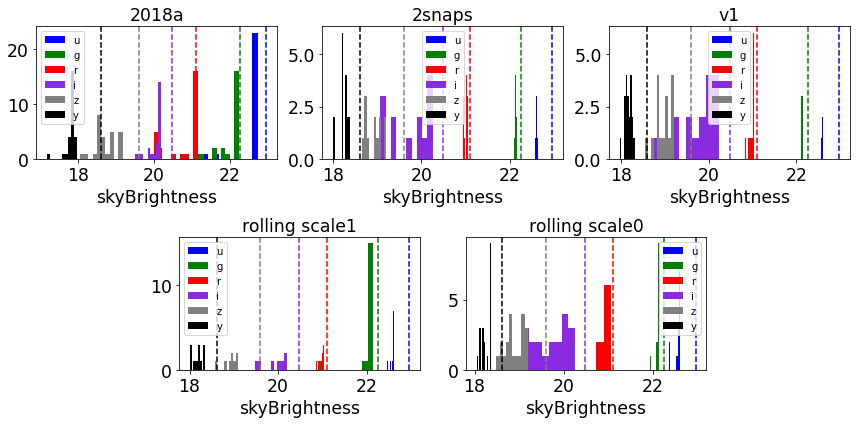

In [56]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
sel_cadence_idx = 0
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax1.hist(df_u['skyBrightness'], bins = 10, color = 'b', label = 'u');
ax1.axvline(22.96, color='b', linestyle='dashed')
ax1.hist(df_g['skyBrightness'], bins = 10, color = 'g', label = 'g');
ax1.axvline(22.26, color='g', linestyle='dashed')
ax1.hist(df_r['skyBrightness'], bins = 10, color = 'r', label = 'r');
ax1.axvline(21.10, color='r', linestyle='dashed')
ax1.hist(df_i['skyBrightness'], bins = 10, color = 'blueviolet', label = 'i');
ax1.axvline(20.48, color='blueviolet', linestyle='dashed')
ax1.hist(df_z['skyBrightness'], bins = 10, color = 'grey', label = 'z');
ax1.axvline(19.60, color='grey', linestyle='dashed')
ax1.hist(df_y['skyBrightness'], bins = 10, color = 'k', label = 'y');
ax1.axvline(18.61, color='k', linestyle='dashed')
ax1.set_title("2018a")
ax1.set_xlabel("skyBrightness")
ax1.legend()  

sel_cadence_idx = 1
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax2.hist(df_u['skyBrightness'], bins = 10, color = 'b', label = 'u');
ax2.axvline(22.96, color='b', linestyle='dashed')
ax2.hist(df_g['skyBrightness'], bins = 10, color = 'g', label = 'g');
ax2.axvline(22.26, color='g', linestyle='dashed')
ax2.hist(df_r['skyBrightness'], bins = 10, color = 'r', label = 'r');
ax2.axvline(21.10, color='r', linestyle='dashed')
ax2.hist(df_i['skyBrightness'], bins = 10, color = 'blueviolet', label = 'i');
ax2.axvline(20.48, color='blueviolet', linestyle='dashed')
ax2.hist(df_z['skyBrightness'], bins = 10, color = 'grey', label = 'z');
ax2.axvline(19.60, color='grey', linestyle='dashed')
ax2.hist(df_y['skyBrightness'], bins = 10, color = 'k', label = 'y');
ax2.axvline(18.61, color='k', linestyle='dashed')
ax2.set_title("2snaps")
ax2.set_xlabel("skyBrightness")
ax2.legend()  

sel_cadence_idx = 2
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']

ax3.hist(df_u['skyBrightness'], bins = 10, color = 'b', label = 'u');
ax3.axvline(22.96, color='b', linestyle='dashed')
ax3.hist(df_g['skyBrightness'], bins = 10, color = 'g', label = 'g');
ax3.axvline(22.26, color='g', linestyle='dashed')
ax3.hist(df_r['skyBrightness'], bins = 10, color = 'r', label = 'r');
ax3.axvline(21.10, color='r', linestyle='dashed')
ax3.hist(df_i['skyBrightness'], bins = 10, color = 'blueviolet', label = 'i');
ax3.axvline(20.48, color='blueviolet', linestyle='dashed')
ax3.hist(df_z['skyBrightness'], bins = 10, color = 'grey', label = 'z');
ax3.axvline(19.60, color='grey', linestyle='dashed')
ax3.hist(df_y['skyBrightness'], bins = 10, color = 'k', label = 'y');
ax3.axvline(18.61, color='k', linestyle='dashed')
ax3.set_title("v1")
ax3.set_xlabel("skyBrightness")
ax3.legend()  

sel_cadence_idx = 3
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax4.hist(df_u['skyBrightness'], bins = 10, color = 'b', label = 'u');
ax4.axvline(22.96, color='b', linestyle='dashed')
ax4.hist(df_g['skyBrightness'], bins = 10, color = 'g', label = 'g');
ax4.axvline(22.26, color='g', linestyle='dashed')
ax4.hist(df_r['skyBrightness'], bins = 10, color = 'r', label = 'r');
ax4.axvline(21.10, color='r', linestyle='dashed')
ax4.hist(df_i['skyBrightness'], bins = 10, color = 'blueviolet', label = 'i');
ax4.axvline(20.48, color='blueviolet', linestyle='dashed')
ax4.hist(df_z['skyBrightness'], bins = 10, color = 'grey', label = 'z');
ax4.axvline(19.60, color='grey', linestyle='dashed')
ax4.hist(df_y['skyBrightness'], bins = 10, color = 'k', label = 'y');
ax4.axvline(18.61, color='k', linestyle='dashed')
ax4.set_title("rolling scale1")
ax4.set_xlabel("skyBrightness")
ax4.legend()  

sel_cadence_idx = 4
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax5.hist(df_u['skyBrightness'], bins = 10, color = 'b', label = 'u');
ax5.axvline(22.96, color='b', linestyle='dashed')
ax5.hist(df_g['skyBrightness'], bins = 10, color = 'g', label = 'g');
ax5.axvline(22.26, color='g', linestyle='dashed')
ax5.hist(df_r['skyBrightness'], bins = 10, color = 'r', label = 'r');
ax5.axvline(21.10, color='r', linestyle='dashed')
ax5.hist(df_i['skyBrightness'], bins = 10, color = 'blueviolet', label = 'i');
ax5.axvline(20.48, color='blueviolet', linestyle='dashed')
ax5.hist(df_z['skyBrightness'], bins = 10, color = 'grey', label = 'z');
ax5.axvline(19.60, color='grey', linestyle='dashed')
ax5.hist(df_y['skyBrightness'], bins = 10, color = 'k', label = 'y');
ax5.axvline(18.61, color='k', linestyle='dashed')
ax5.set_title("rolling scale0")
ax5.set_xlabel("skyBrightness")
ax5.legend()  


plt.tight_layout()

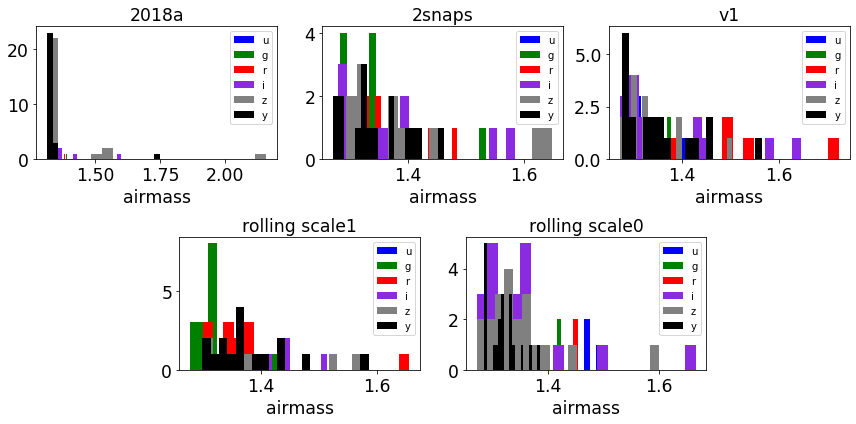

In [57]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
sel_cadence_idx = 0
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax1.hist(df_u['airmass'], bins = 20, color = 'b', label = 'u');
ax1.hist(df_g['airmass'], bins = 20, color = 'g', label = 'g');
ax1.hist(df_r['airmass'], bins = 20, color = 'r', label = 'r');
ax1.hist(df_i['airmass'], bins = 20, color = 'blueviolet', label = 'i');
ax1.hist(df_z['airmass'], bins = 20, color = 'grey', label = 'z');
ax1.hist(df_y['airmass'], bins = 20, color = 'k', label = 'y');
ax1.set_title("2018a")
ax1.set_xlabel("airmass")
ax1.legend()  

sel_cadence_idx = 1
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax2.hist(df_u['airmass'], bins = 20, color = 'b', label = 'u');
ax2.hist(df_g['airmass'], bins = 20, color = 'g', label = 'g');
ax2.hist(df_r['airmass'], bins = 20, color = 'r', label = 'r');
ax2.hist(df_i['airmass'], bins = 20, color = 'blueviolet', label = 'i');
ax2.hist(df_z['airmass'], bins = 20, color = 'grey', label = 'z');
ax2.hist(df_y['airmass'], bins = 20, color = 'k', label = 'y');
ax2.set_title("2snaps")
ax2.set_xlabel("airmass")
ax2.legend()  

sel_cadence_idx = 2
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax3.hist(df_u['airmass'], bins = 20, color = 'b', label = 'u');
ax3.hist(df_g['airmass'], bins = 20, color = 'g', label = 'g');
ax3.hist(df_r['airmass'], bins = 20, color = 'r', label = 'r');
ax3.hist(df_i['airmass'], bins = 20, color = 'blueviolet', label = 'i');
ax3.hist(df_z['airmass'], bins = 20, color = 'grey', label = 'z');
ax3.hist(df_y['airmass'], bins = 20, color = 'k', label = 'y');
ax3.set_title("v1")
ax3.set_xlabel("airmass")
ax3.legend()  

sel_cadence_idx = 3
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax4.hist(df_u['airmass'], bins = 20, color = 'b', label = 'u');
ax4.hist(df_g['airmass'], bins = 20, color = 'g', label = 'g');
ax4.hist(df_r['airmass'], bins = 20, color = 'r', label = 'r');
ax4.hist(df_i['airmass'], bins = 20, color = 'blueviolet', label = 'i');
ax4.hist(df_z['airmass'], bins = 20, color = 'grey', label = 'z');
ax4.hist(df_y['airmass'], bins = 20, color = 'k', label = 'y');
ax4.set_title("rolling scale1")
ax4.set_xlabel("airmass")
ax4.legend()  

sel_cadence_idx = 4
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax5.hist(df_u['airmass'], bins = 20, color = 'b', label = 'u');
ax5.hist(df_g['airmass'], bins = 20, color = 'g', label = 'g');
ax5.hist(df_r['airmass'], bins = 20, color = 'r', label = 'r');
ax5.hist(df_i['airmass'], bins = 20, color = 'blueviolet', label = 'i');
ax5.hist(df_z['airmass'], bins = 20, color = 'grey', label = 'z');
ax5.hist(df_y['airmass'], bins = 20, color = 'k', label = 'y');
ax5.set_title("rolling scale0")
ax5.set_xlabel("airmass")
ax5.legend()  


plt.tight_layout()

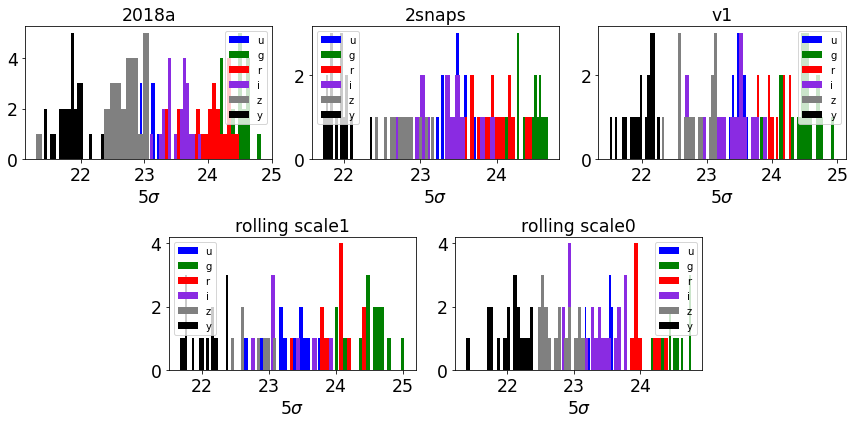

In [58]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
sel_cadence_idx = 0
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax1.hist(df_u['fiveSigmaDepth'], bins = 20, color = 'b', label = 'u');
ax1.hist(df_g['fiveSigmaDepth'], bins = 20, color = 'g', label = 'g');
ax1.hist(df_r['fiveSigmaDepth'], bins = 20, color = 'r', label = 'r');
ax1.hist(df_i['fiveSigmaDepth'], bins = 20, color = 'blueviolet', label = 'i');
ax1.hist(df_z['fiveSigmaDepth'], bins = 20, color = 'grey', label = 'z');
ax1.hist(df_y['fiveSigmaDepth'], bins = 20, color = 'k', label = 'y');
ax1.set_title("2018a")
ax1.set_xlabel("$5\sigma$")
ax1.legend()  

sel_cadence_idx = 1
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax2.hist(df_u['fiveSigmaDepth'], bins = 20, color = 'b', label = 'u');
ax2.hist(df_g['fiveSigmaDepth'], bins = 20, color = 'g', label = 'g');
ax2.hist(df_r['fiveSigmaDepth'], bins = 20, color = 'r', label = 'r');
ax2.hist(df_i['fiveSigmaDepth'], bins = 20, color = 'blueviolet', label = 'i');
ax2.hist(df_z['fiveSigmaDepth'], bins = 20, color = 'grey', label = 'z');
ax2.hist(df_y['fiveSigmaDepth'], bins = 20, color = 'k', label = 'y');
ax2.set_title("2snaps")
ax2.set_xlabel("$5\sigma$")
ax2.legend()  

sel_cadence_idx = 2
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax3.hist(df_u['fiveSigmaDepth'], bins = 20, color = 'b', label = 'u');
ax3.hist(df_g['fiveSigmaDepth'], bins = 20, color = 'g', label = 'g');
ax3.hist(df_r['fiveSigmaDepth'], bins = 20, color = 'r', label = 'r');
ax3.hist(df_i['fiveSigmaDepth'], bins = 20, color = 'blueviolet', label = 'i');
ax3.hist(df_z['fiveSigmaDepth'], bins = 20, color = 'grey', label = 'z');
ax3.hist(df_y['fiveSigmaDepth'], bins = 20, color = 'k', label = 'y');
ax3.set_title("v1")
ax3.set_xlabel("$5\sigma$")
ax3.legend()  

sel_cadence_idx = 3
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax4.hist(df_u['fiveSigmaDepth'], bins = 20, color = 'b', label = 'u');
ax4.hist(df_g['fiveSigmaDepth'], bins = 20, color = 'g', label = 'g');
ax4.hist(df_r['fiveSigmaDepth'], bins = 20, color = 'r', label = 'r');
ax4.hist(df_i['fiveSigmaDepth'], bins = 20, color = 'blueviolet', label = 'i');
ax4.hist(df_z['fiveSigmaDepth'], bins = 20, color = 'grey', label = 'z');
ax4.hist(df_y['fiveSigmaDepth'], bins = 20, color = 'k', label = 'y');
ax4.set_title("rolling scale1")
ax4.set_xlabel("$5\sigma$")
ax4.legend()  

sel_cadence_idx = 4
  
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
df_u = df_good[df_good["filter"].values == 'u']
df_g = df_good[df_good["filter"].values == 'g']
df_r = df_good[df_good["filter"].values == 'r']
df_i = df_good[df_good["filter"].values == 'i']
df_z = df_good[df_good["filter"].values == 'z']
df_y = df_good[df_good["filter"].values == 'y']
    
ax5.hist(df_u['fiveSigmaDepth'], bins = 20, color = 'b', label = 'u');
ax5.hist(df_g['fiveSigmaDepth'], bins = 20, color = 'g', label = 'g');
ax5.hist(df_r['fiveSigmaDepth'], bins = 20, color = 'r', label = 'r');
ax5.hist(df_i['fiveSigmaDepth'], bins = 20, color = 'blueviolet', label = 'i');
ax5.hist(df_z['fiveSigmaDepth'], bins = 20, color = 'grey', label = 'z');
ax5.hist(df_y['fiveSigmaDepth'], bins = 20, color = 'k', label = 'y');
ax5.set_title("rolling scale0")
ax5.set_xlabel("$5\sigma$")
ax5.legend()  


plt.tight_layout()

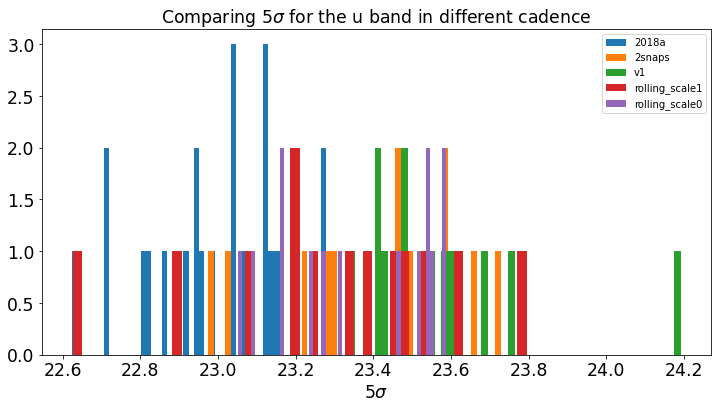

In [60]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_u = df_good[df_good["filter"].values == 'u']
    

    plt.hist(df_u['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the u band in different cadence")
plt.xlabel('$5\sigma$')
plt.legend()

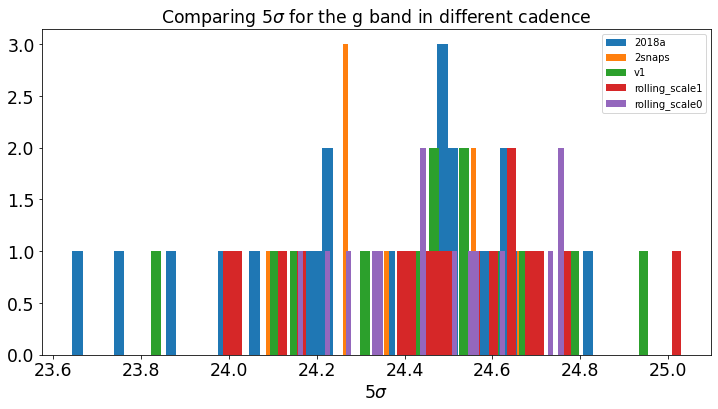

In [61]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_g = df_good[df_good["filter"].values == 'g']
    

    plt.hist(df_g['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the g band in different cadence")
plt.xlabel('$5\sigma$')
plt.legend()

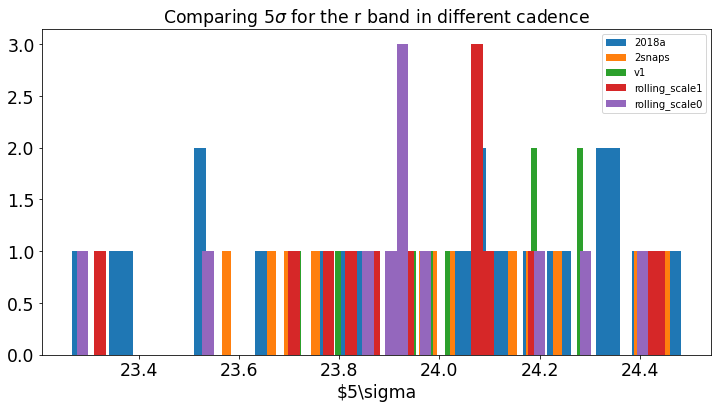

In [62]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_r = df_good[df_good["filter"].values == 'r']
    

    plt.hist(df_r['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the r band in different cadence")
plt.xlabel('$5\sigma')
plt.legend()

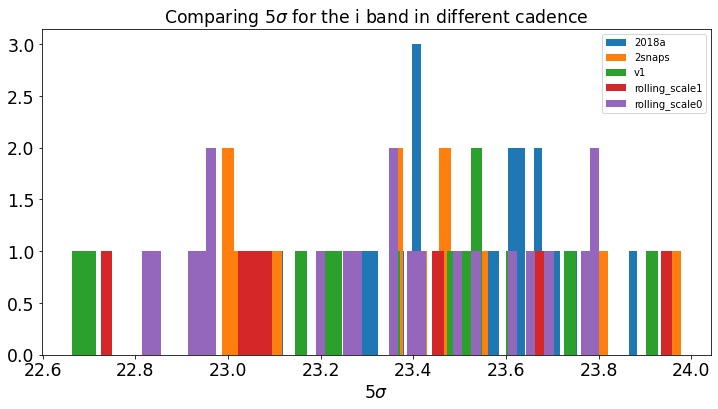

In [63]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_i = df_good[df_good["filter"].values == 'i']
    

    plt.hist(df_i['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the i band in different cadence")
plt.xlabel('$5\sigma$')
plt.legend()

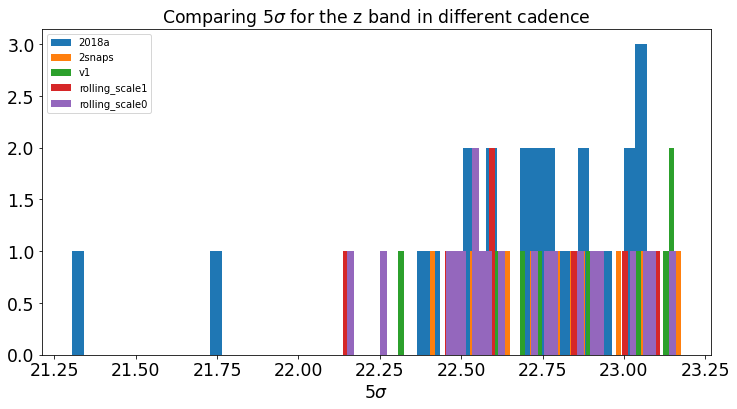

In [64]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_z = df_good[df_good["filter"].values == 'z']
    

    plt.hist(df_z['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the z band in different cadence")
plt.xlabel('$5\sigma$')
plt.legend()

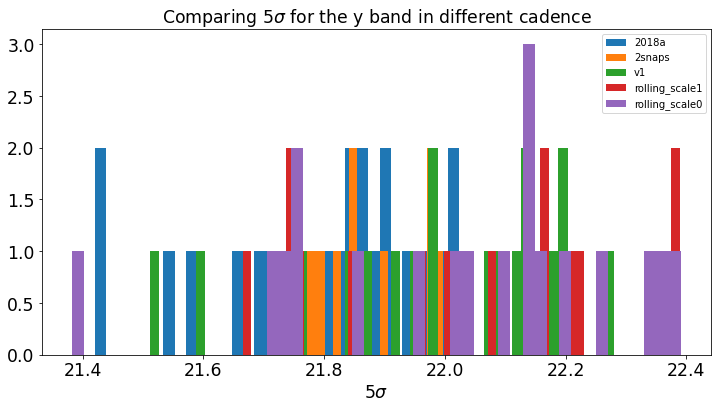

In [65]:
for i in range (len(all_my_cadence_files)) :
    
    cadence_file=os.path.join(dir_cadences,all_my_cadence_files[i])
    df = pd.read_csv(cadence_file, index_col=0)
    df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]
    
    df_y = df_good[df_good["filter"].values == 'y']
    

    plt.hist(df_y['fiveSigmaDepth'], bins = 50, label = all_names[i]);


plt.title("$5\sigma$ for the y band in different cadence")
plt.xlabel('$5\sigma$')
plt.legend()